In [2]:
"""
2018-4-21:
finished outlier cleaning...now let's run XGBoost on the cleaned ones and see how it does:
training&valid best 0.9221654742823935
Kaggle improved from 1614 -> 1202 (with log rsme score = 0.12567)
It seems removing outlier definitely helps, but not that much given we don't have that many outliers

2018-4-20:

Ok, after work1, and XGBoost edition1, i have applied it and got some score of this House Price Prediction
Challenge. 

Now the goal is to learn from the top perfomers and learn how to make up the difference.
The first one I found is <Data Pre-Processing> --- how to treat missing values and outliers
ref: https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard

Here we go
"""


import pandas as pd
import numpy as np
import os

%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew #for some statistics

#this is cool:
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [28]:
dirctory = os.getcwd()

train = pd.read_csv(str(dirctory)+"/kaggle_house_pred_train.csv")
test = pd.read_csv(str(dirctory)+"/kaggle_house_pred_test.csv")
all_X = pd.concat((train.loc[:, 'MSSubClass':'SaleCondition'],
                      test.loc[:, 'MSSubClass':'SaleCondition']))
o_train = train.copy()
o_test = test.copy()
o_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [29]:
#check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(train.shape))
print("The test data size before dropping Id feature is : {} ".format(test.shape))

#Save the 'Id' column
train_ID = train['Id']
test_ID = test['Id']

#Now drop the  'Id' colum since it's unnecessary for  the prediction process.
train.drop("Id", axis = 1, inplace = True)
test.drop("Id", axis = 1, inplace = True)

#check again the data size after dropping the 'Id' variable
print("\nThe train data size after dropping Id feature is : {} ".format(train.shape)) 
print("The test data size after dropping Id feature is : {} ".format(test.shape))

The train data size before dropping Id feature is : (1460, 81) 
The test data size before dropping Id feature is : (1459, 80) 

The train data size after dropping Id feature is : (1460, 80) 
The test data size after dropping Id feature is : (1459, 79) 


In [30]:
cols = train.columns
print(cols)
bad_cols = []
train.head()

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [105]:
numeric_feats = train.dtypes[train.dtypes != "object"].index
print(len(numeric_feats))
print(numeric_feats)

37
Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')


{160, 70, 40, 75, 45, 80, 50, 20, 85, 180, 30, 120, 150, 90, 60, 190}
count    2919.000000
mean       57.137718
std        42.517628
min        20.000000
25%        20.000000
50%        50.000000
75%        70.000000
max       190.000000
Name: MSSubClass, dtype: float64


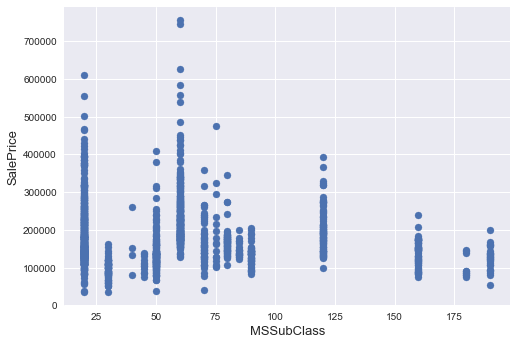

In [50]:
#LOOK into columns: 1. MSSubClass
#humm...strange...what is a MSSubClass--building class?
print(set(all_X.MSSubClass.unique()))
print(all_X.MSSubClass.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train['MSSubClass'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MSSubClass', fontsize=13)
plt.show()
plt.close()
#T--from the plot we can see this data is...very weird. think about drop it
bad_cols.append('MSSubClass')

In [ ]:
# 2. MSZoning: The general zoning classification
# string-categoric column, skip. 

{nan, 21.0, 24.0, 30.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0, 48.0, 49.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 56.0, 57.0, 58.0, 59.0, 60.0, 61.0, 62.0, 63.0, 64.0, 65.0, 66.0, 67.0, 68.0, 69.0, 70.0, 71.0, 72.0, 73.0, 74.0, 75.0, 76.0, 77.0, 78.0, 79.0, 80.0, 81.0, 82.0, 83.0, 84.0, 85.0, 86.0, 87.0, 88.0, 89.0, 90.0, 91.0, 92.0, 93.0, 94.0, 95.0, 96.0, 97.0, 98.0, 99.0, 100.0, 101.0, 102.0, 103.0, 104.0, 105.0, 106.0, 107.0, 108.0, 109.0, 110.0, 111.0, 112.0, 114.0, 115.0, 116.0, 118.0, 120.0, 121.0, 122.0, 124.0, 128.0, 129.0, 130.0, 134.0, 137.0, 138.0, 140.0, 141.0, 144.0, 149.0, 152.0, 153.0, 160.0, 168.0, 174.0, 182.0}
count    1198.000000
mean       69.577629
std        22.069047
min        21.000000
25%        59.000000
50%        69.000000
75%        80.000000
max       182.000000
Name: LotFrontage, dtype: float64


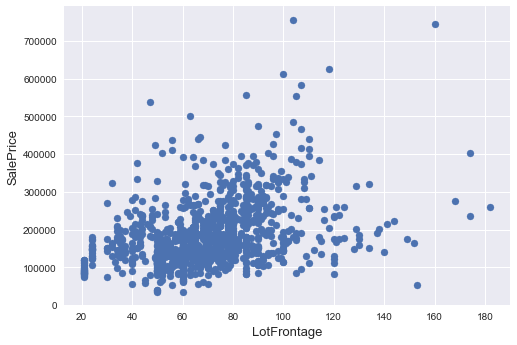

In [63]:
#LOOK into columns: 2. LotFrontage-Linear feet of street connected to property
print(set(train.LotFrontage.unique()))
print(train.LotFrontage.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train['LotFrontage'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()
plt.close()

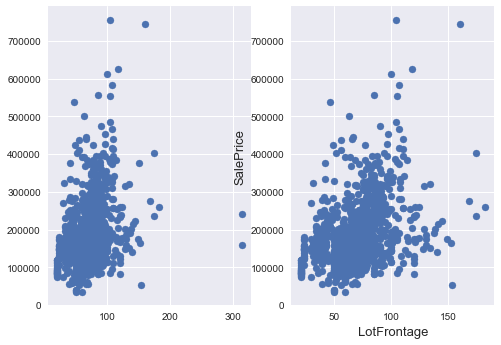

std of column is reduced by:  2.2157046535734395


In [66]:
#T--from the plot we can see there are two outliers near the end--so let's remove it
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['LotFrontage']>250) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['LotFrontage'], y = o_train['SalePrice'])
ax[1].scatter(x = train['LotFrontage'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotFrontage', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.LotFrontage.std() - train.LotFrontage.std())

count     1454.000000
mean     10047.440165
std       5454.098257
min       1300.000000
25%       7536.250000
50%       9458.500000
75%      11546.250000
max      70761.000000
Name: LotArea, dtype: float64


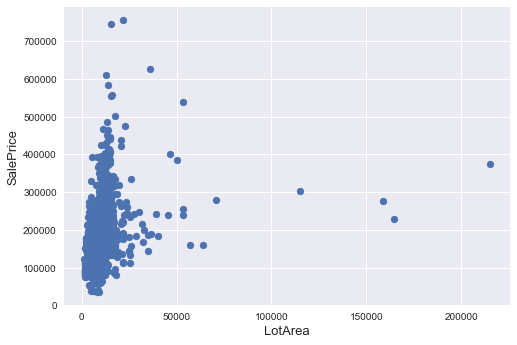

In [68]:
#LOOK into columns: 3. LotArea-Lot size in square feet
#print(set(all_X.LotArea.unique()))
print(train.LotArea.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train['LotArea'], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()

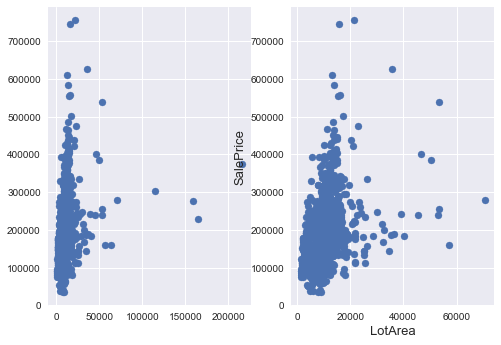

std of column is reduced by:  4527.1666755534125


In [69]:
#T--from the plot we can see there are two outliers near the end--so try to let's remove it
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['LotArea']>100000) & (train['SalePrice']<400000)].index)
ax[0].scatter(x = o_train['LotArea'], y = o_train['SalePrice'])
ax[1].scatter(x = train['LotArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('LotArea', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.LotArea.std() - train.LotArea.std())

count    1454.000000
mean        6.095598
std         1.381151
min         1.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        10.000000
Name: OverallQual, dtype: float64


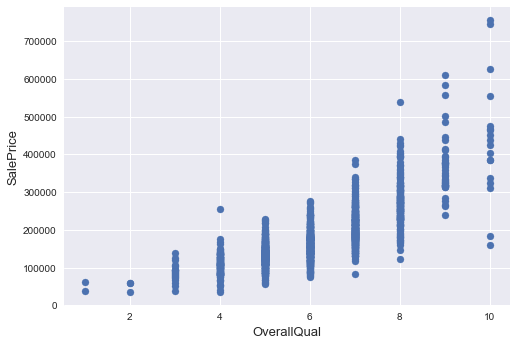

In [72]:
#LOOK into columns: 4. OverallQual-Overall material and finish quality
#print(set(all_X.LotArea.unique()))
print(train.OverallQual.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train['OverallQual'], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallQual', fontsize=13)
plt.show() 
# this feature looks pretty good

count    1454.000000
mean        5.574278
std         1.113478
min         1.000000
25%         5.000000
50%         5.000000
75%         6.000000
max         9.000000
Name: OverallCond, dtype: float64


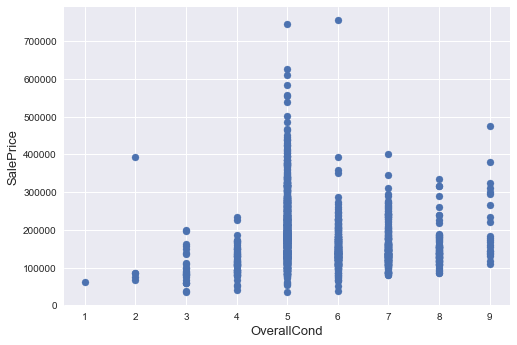

In [73]:
#LOOK into columns: 5. OverallCond-Overall condition rating
#print(set(all_X.LotArea.unique()))
print(train.OverallCond.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train['OverallCond'], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OverallCond', fontsize=13)
plt.show() 
# this feature looks OK...

count    1454.000000
mean     1971.268226
std        30.245513
min      1872.000000
25%      1954.000000
50%      1973.000000
75%      2000.000000
max      2010.000000
Name: YearBuilt, dtype: float64


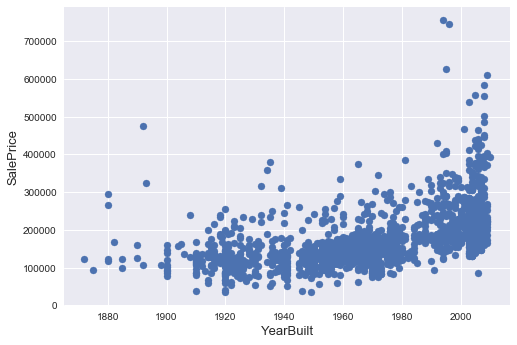

In [74]:
#LOOK into columns: 6. YearBuilt-YearBuilt: Original construction date
#print(set(all_X.LotArea.unique()))
print(train.YearBuilt.describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train['YearBuilt'], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('YearBuilt', fontsize=13)
plt.show() 
# this feature looks OK...

YearRemodAdd
count    1454.000000
mean     1984.835626
std        20.645431
min      1950.000000
25%      1967.000000
50%      1994.000000
75%      2004.000000
max      2010.000000
Name: YearRemodAdd, dtype: float64


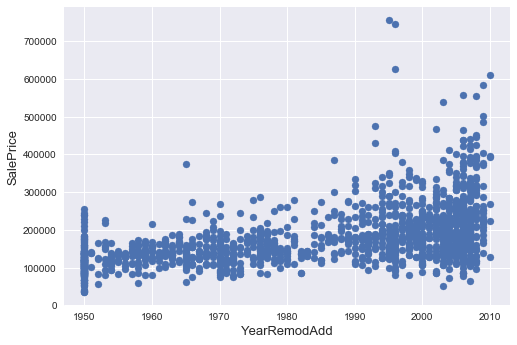

In [78]:
#LOOK into columns: 7. YearRemodAdd-Remodel date
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[6]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

MasVnrArea
count    1446.000000
mean      102.995851
std       180.084436
min         0.000000
25%         0.000000
50%         0.000000
75%       164.750000
max      1600.000000
Name: MasVnrArea, dtype: float64


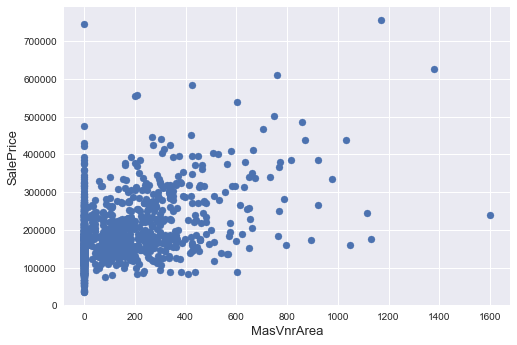

In [79]:
#LOOK into columns: 8. MasVnrArea-Masonry veneer area in square feet
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[7]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...just the far right one seems a bit strange

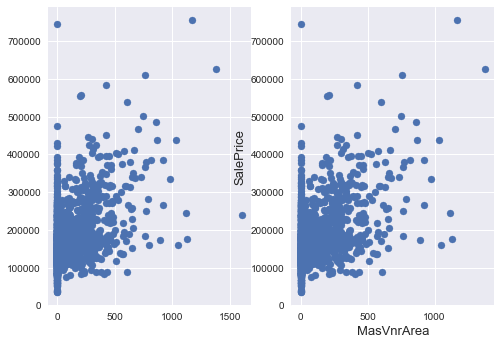

std of column is reduced by:  5.282717735478258


In [81]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['MasVnrArea']>1500) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['MasVnrArea'], y = o_train['SalePrice'])
ax[1].scatter(x = train['MasVnrArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MasVnrArea', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.MasVnrArea.std() - train.MasVnrArea.std())

BsmtFinSF1
count    1453.000000
mean      438.124570
std       434.748336
min         0.000000
25%         0.000000
50%       380.000000
75%       708.000000
max      2260.000000
Name: BsmtFinSF1, dtype: float64


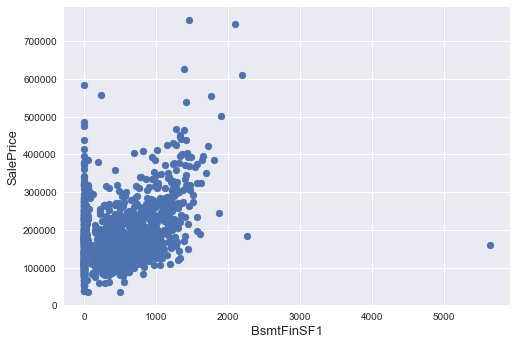

In [82]:
#LOOK into columns: 9. BsmtFinSF1-Type 1 finished square feet
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[8]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...just the far right one seems a bit strange

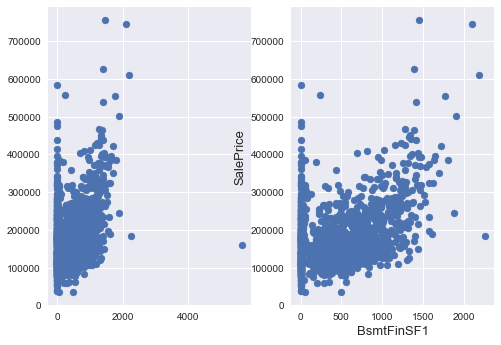

std of column is reduced by:  21.349754427359812


In [83]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['BsmtFinSF1']>5000) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['BsmtFinSF1'], y = o_train['SalePrice'])
ax[1].scatter(x = train['BsmtFinSF1'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('BsmtFinSF1', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.BsmtFinSF1.std() - train.BsmtFinSF1.std())

BsmtFinSF2
count    1453.000000
mean       46.108052
std       160.383167
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max      1474.000000
Name: BsmtFinSF2, dtype: float64


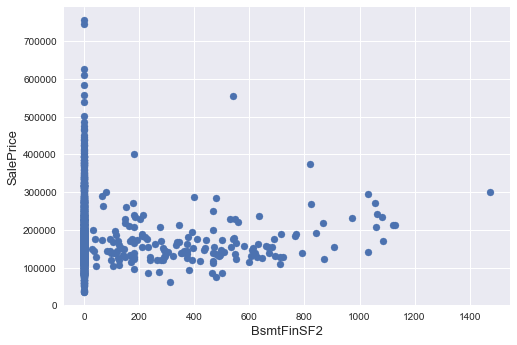

In [84]:
#LOOK into columns: 10. BsmtFinSF2: Type 2 finished square feet
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[9]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...just the far right one seems a bit strange

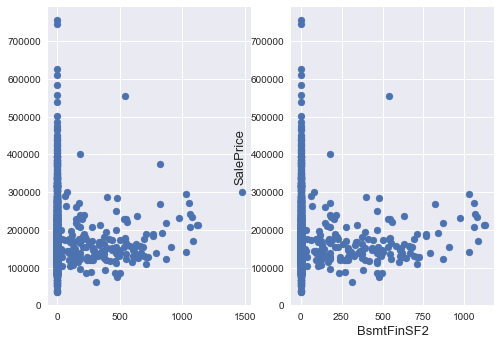

std of column is reduced by:  5.324502626732539


In [85]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['BsmtFinSF2']>1400) & (train['SalePrice']<400000)].index)
ax[0].scatter(x = o_train['BsmtFinSF2'], y = o_train['SalePrice'])
ax[1].scatter(x = train['BsmtFinSF2'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('BsmtFinSF2', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.BsmtFinSF2.std() - train.BsmtFinSF2.std())

BsmtUnfSF
count    1452.000000
mean      568.777548
std       442.254163
min         0.000000
25%       224.000000
50%       481.500000
75%       810.250000
max      2336.000000
Name: BsmtUnfSF, dtype: float64


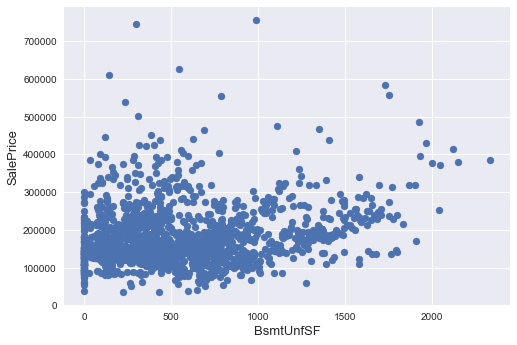

In [86]:
#LOOK into columns: 11. BsmtUnfSF: Unfinished square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[10]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...probably not very informative

TotalBsmtSF
count    1452.000000
mean     1052.309229
std       417.532539
min         0.000000
25%       795.000000
50%       990.500000
75%      1291.500000
max      3206.000000
Name: TotalBsmtSF, dtype: float64


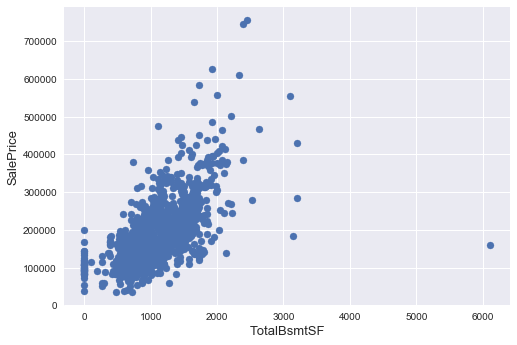

In [87]:
#LOOK into columns: 12. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[11]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = o_train[str(feature_name)], y = o_train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...let's remove this far far right one

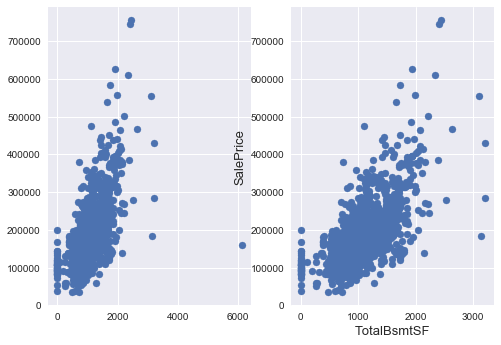

std of column is reduced by:  21.172785372218243


In [88]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['TotalBsmtSF']>5000) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['TotalBsmtSF'], y = o_train['SalePrice'])
ax[1].scatter(x = train['TotalBsmtSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotalBsmtSF', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.TotalBsmtSF.std() - train.TotalBsmtSF.std())

1stFlrSF
count    1452.000000
mean     1157.867080
std       374.093478
min       334.000000
25%       882.000000
50%      1086.000000
75%      1383.000000
max      3228.000000
Name: 1stFlrSF, dtype: float64


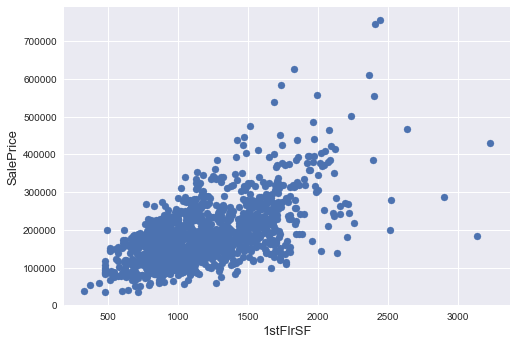

In [89]:
#LOOK into columns: 13. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[12]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

2ndFlrSF
count    1452.000000
mean      346.170799
std       436.179647
min         0.000000
25%         0.000000
50%         0.000000
75%       728.000000
max      2065.000000
Name: 2ndFlrSF, dtype: float64


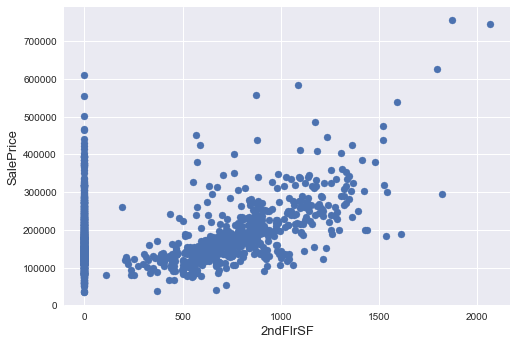

In [90]:
#LOOK into columns: 14. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[13]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

LowQualFinSF
count    1452.000000
mean        5.876722
std        48.754995
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max       572.000000
Name: LowQualFinSF, dtype: float64


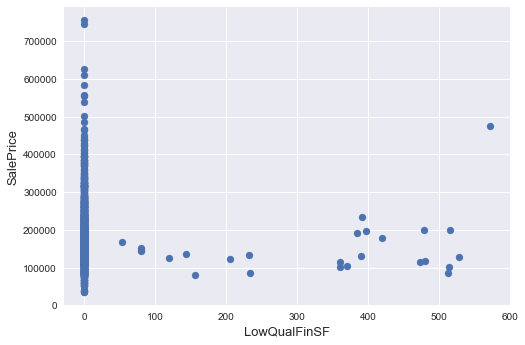

In [91]:
#LOOK into columns: 15. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[14]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

GrLivArea
count    1452.000000
mean     1509.914601
std       513.763294
min       334.000000
25%      1128.000000
50%      1457.000000
75%      1771.750000
max      4676.000000
Name: GrLivArea, dtype: float64


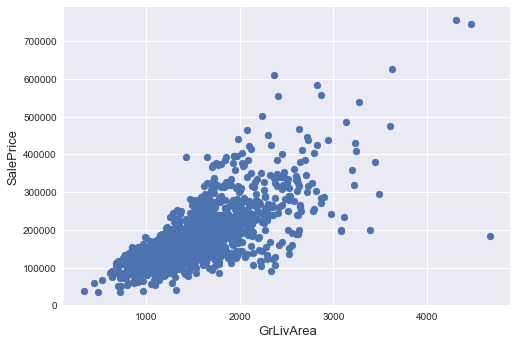

In [93]:
#LOOK into columns: 16. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[15]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

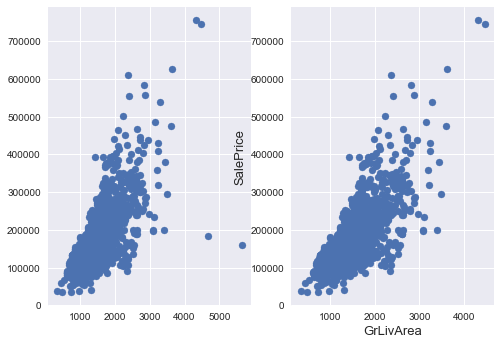

std of column is reduced by:  18.3149039006085


In [94]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['GrLivArea'], y = o_train['SalePrice'])
ax[1].scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.GrLivArea.std() - train.GrLivArea.std())

BsmtFullBath
count    1451.000000
mean        0.421089
std         0.514423
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         3.000000
Name: BsmtFullBath, dtype: float64


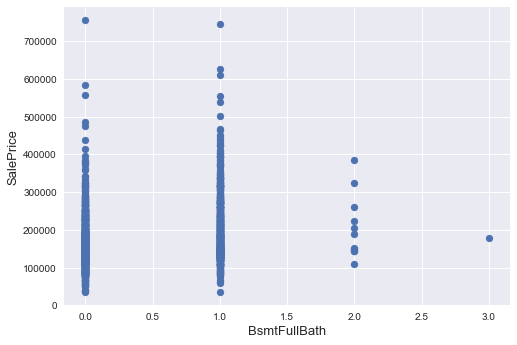

In [95]:
#LOOK into columns: 17. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[16]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK... seems not that informative

BsmtHalfBath
count    1451.000000
mean        0.057202
std         0.238172
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: BsmtHalfBath, dtype: float64


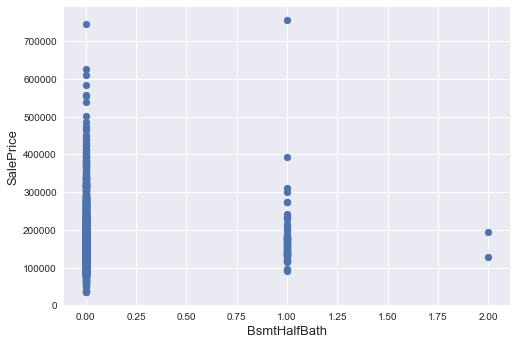

In [96]:
#LOOK into columns: 18. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[17]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

FullBath
count    1451.000000
mean        1.561682
std         0.550379
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         3.000000
Name: FullBath, dtype: float64


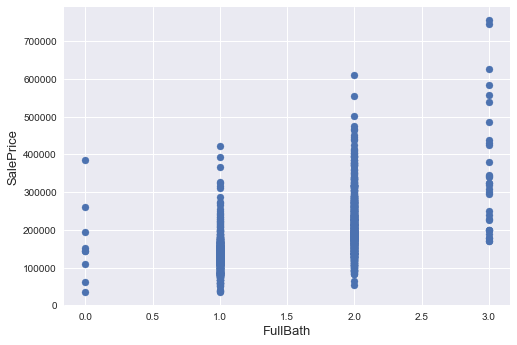

In [97]:
#LOOK into columns: 19. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[18]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

HalfBath
count    1451.000000
mean        0.382495
std         0.502899
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         2.000000
Name: HalfBath, dtype: float64


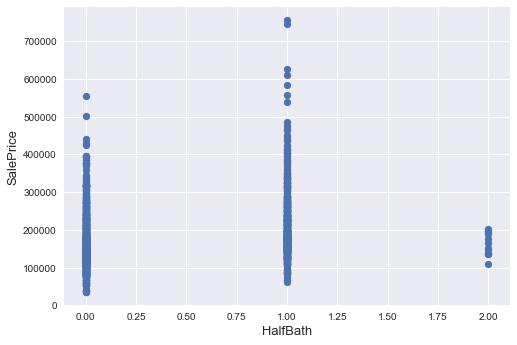

In [98]:
#LOOK into columns: 20. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[19]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

BedroomAbvGr
count    1451.000000
mean        2.864232
std         0.816322
min         0.000000
25%         2.000000
50%         3.000000
75%         3.000000
max         8.000000
Name: BedroomAbvGr, dtype: float64


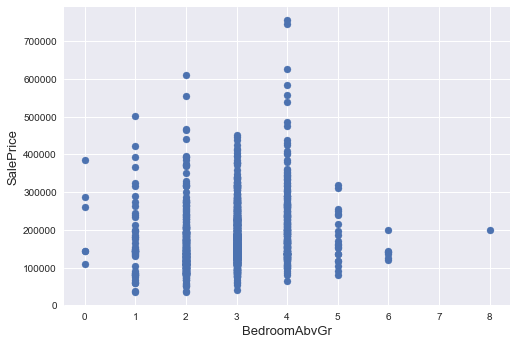

In [99]:
#LOOK into columns: 21. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[20]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

KitchenAbvGr
count    1451.000000
mean        1.046864
std         0.220990
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: KitchenAbvGr, dtype: float64


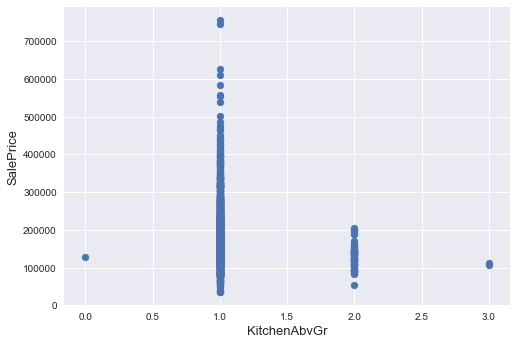

In [100]:
#LOOK into columns: 22. TotalBsmtSF: Total square feet of basement area
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[21]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

TotRmsAbvGrd
count    1451.000000
mean        6.507236
std         1.616867
min         2.000000
25%         5.000000
50%         6.000000
75%         7.000000
max        14.000000
Name: TotRmsAbvGrd, dtype: float64


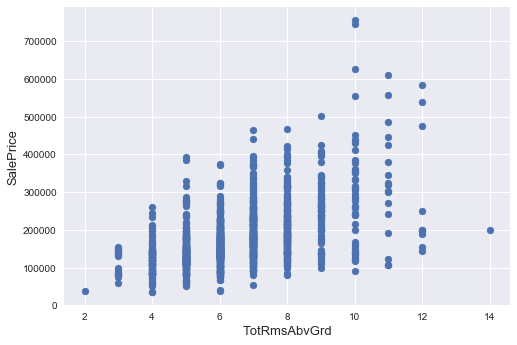

In [101]:
#LOOK into columns: 23. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[22]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

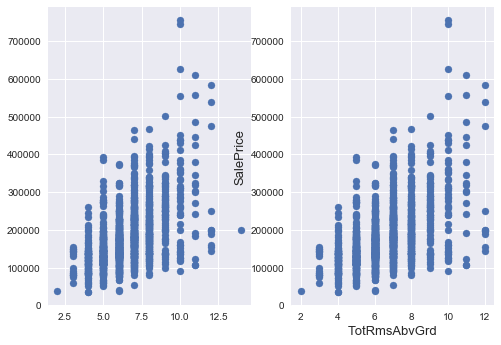

std of column is reduced by:  0.01999913262226971


In [102]:
# so..from the figure we can see the trend is positive, thus the far right one might be outlier
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['TotRmsAbvGrd']>13) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['TotRmsAbvGrd'], y = o_train['SalePrice'])
ax[1].scatter(x = train['TotRmsAbvGrd'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('TotRmsAbvGrd', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.TotRmsAbvGrd.std() - train.TotRmsAbvGrd.std())

Fireplaces
count    1450.000000
mean        0.606897
std         0.639148
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         3.000000
Name: Fireplaces, dtype: float64


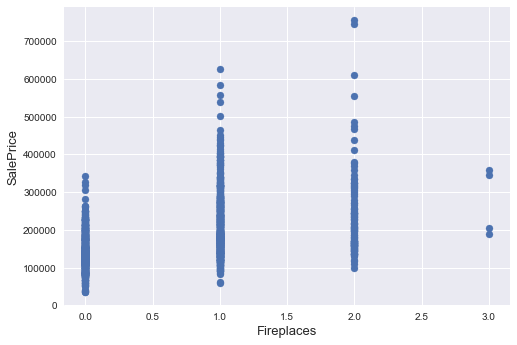

In [103]:
#LOOK into columns: 24. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[23]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

GarageYrBlt
count    1370.000000
mean     1978.497810
std        24.722337
min      1900.000000
25%      1961.000000
50%      1980.000000
75%      2002.000000
max      2010.000000
Name: GarageYrBlt, dtype: float64


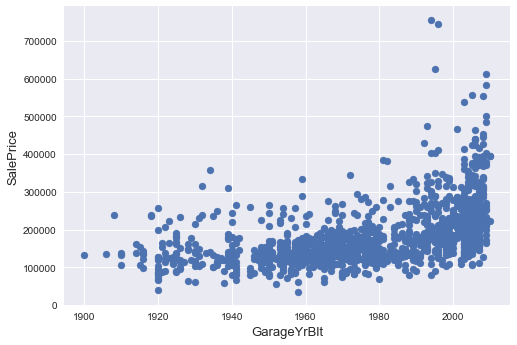

In [104]:
#LOOK into columns: 25. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[24]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

GarageCars
count    1450.000000
mean        1.766207
std         0.747549
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64


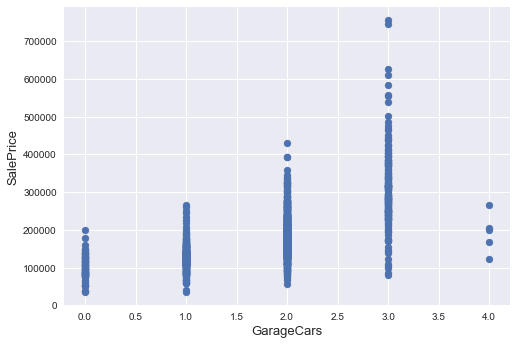

In [106]:
#LOOK into columns: 26. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[25]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK...

GarageArea
count    1450.000000
mean      472.015172
std       212.290869
min         0.000000
25%       328.500000
50%       478.000000
75%       576.000000
max      1390.000000
Name: GarageArea, dtype: float64


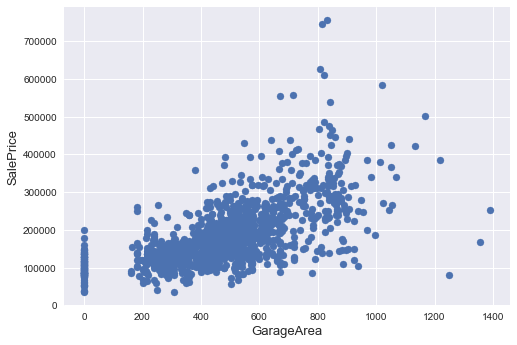

In [107]:
#LOOK into columns: 27. TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
#print(set(all_X.LotArea.unique()))
feature_name = numeric_feats[26]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK... the far right 3 seems a bit strange
# not super sure about this one---since a very big garage can imply the location
# --big garage usually means it's rural area and land won't be very expensive

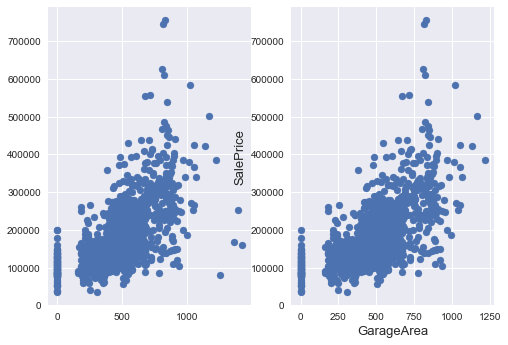

std of column is reduced by:  4.955310477144991


In [109]:
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['GarageArea']>1200) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['GarageArea'], y = o_train['SalePrice'])
ax[1].scatter(x = train['GarageArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GarageArea', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.GarageArea.std() - train.GarageArea.std())

WoodDeckSF
count    1447.000000
mean       93.631652
std       124.149150
min         0.000000
25%         0.000000
50%         0.000000
75%       168.000000
max       857.000000
Name: WoodDeckSF, dtype: float64


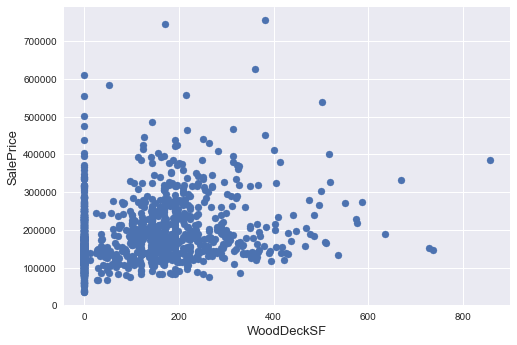

In [110]:
feature_name = numeric_feats[27] #WoodDeckSF: Wood deck area in square feet
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 
# this feature looks OK... 

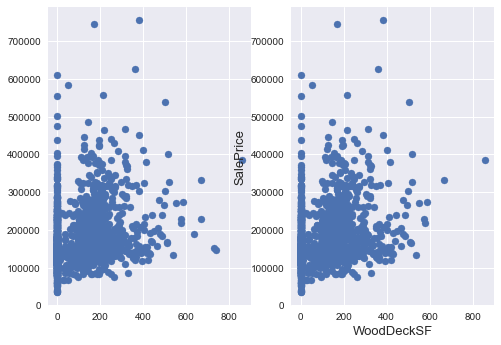

std of column is reduced by:  4.196204547558153


In [112]:
# WoodDeckSF: Wood deck area in square feet
# from the figure, despite the ones don't have a wood deck, it seems quite positive
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['WoodDeckSF']>600) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['WoodDeckSF'], y = o_train['SalePrice'])
ax[1].scatter(x = train['WoodDeckSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('WoodDeckSF', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.WoodDeckSF.std() - train.WoodDeckSF.std())

OpenPorchSF
count    1444.000000
mean       46.234072
std        65.490573
min         0.000000
25%         0.000000
50%        24.500000
75%        68.000000
max       547.000000
Name: OpenPorchSF, dtype: float64


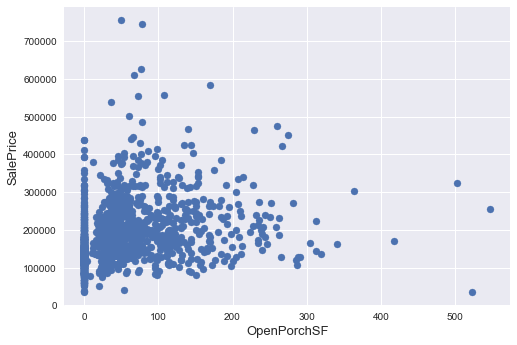

In [113]:
feature_name = numeric_feats[28] #OpenPorchSF: Open porch area in square feet
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
#ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 

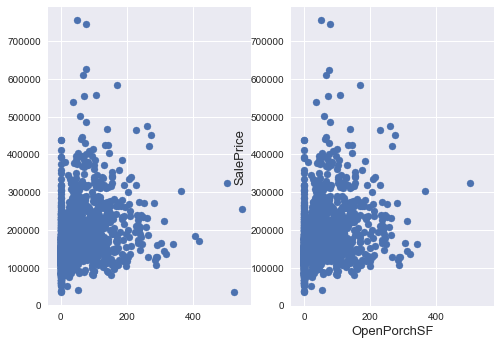

std of column is reduced by:  4.053941685130859


In [115]:
# #OpenPorchSF: Open porch area in square feet
# from the figure, despite the ones don't have an open porch, it seems quite positive
fig, ax = plt.subplots(1,2, sharex=True)
train = train.drop(train[(train['OpenPorchSF']>400) & (train['SalePrice']<300000)].index)
ax[0].scatter(x = o_train['OpenPorchSF'], y = o_train['SalePrice'])
ax[1].scatter(x = train['OpenPorchSF'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('OpenPorchSF', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.OpenPorchSF.std() - train.OpenPorchSF.std())

MiscVal
count     1441.000000
mean        41.765441
std        497.791654
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      15500.000000
Name: MiscVal, dtype: float64


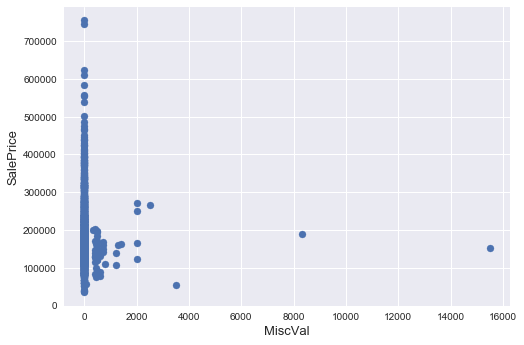

In [120]:
#29 EnclosedPorch seems ok;
#30 3SsnPorch seems ok;
#31 ScreenPorch seems ok;
#32 PoolArea seems ok, but seems not very informative
#33 MiscVal: $Value of miscellaneous feature---
feature_name = numeric_feats[33]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 

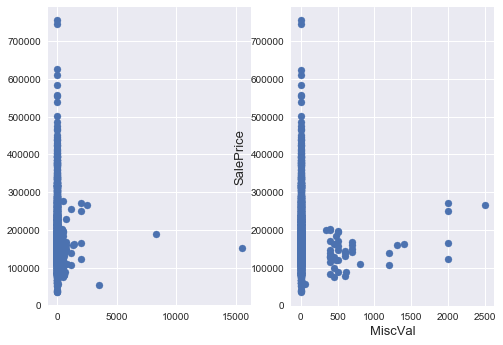

std of column is reduced by:  335.2307903627834


In [121]:
# MiscVal: $Value of miscellaneous feature---
# from the figure, it seems quite positive other than the right-most three ones
fig, ax = plt.subplots(1,2)
train = train.drop(train[(train['MiscVal']>3000) & (train['SalePrice']<200000)].index)
ax[0].scatter(x = o_train['MiscVal'], y = o_train['SalePrice'])
ax[1].scatter(x = train['MiscVal'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('MiscVal', fontsize=13)
plt.show()
print("std of column is reduced by: ",o_train.MiscVal.std() - train.MiscVal.std())

YrSold
count    1438.000000
mean     2007.817107
std         1.331305
min      2006.000000
25%      2007.000000
50%      2008.000000
75%      2009.000000
max      2010.000000
Name: YrSold, dtype: float64


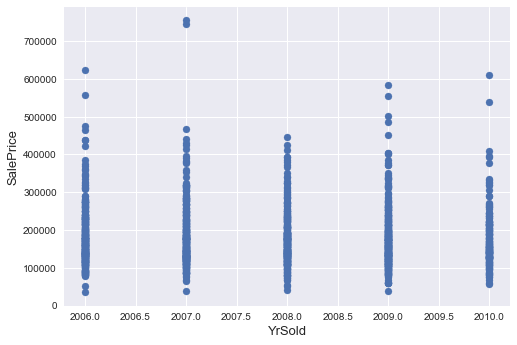

In [126]:
#34, MoSold seems ok but not informative
#35, YrSold, same above
feature_name = numeric_feats[35]
print(feature_name)
print(train[str(feature_name)].describe())
fig, ax = plt.subplots()
ax.scatter(x = train[str(feature_name)], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel(str(feature_name), fontsize=13)
plt.show() 

## By far we have looked into all the numerical columns for outliers, now let's look into missing values...let's output the prune datafram and open a new notebook!

In [131]:
train.to_csv('train1.csv', index=False)

In [129]:
train.describe()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1438.000000,1185.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1430.000000,1438.000000,1438.000000,...,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000,1438.000000
mean,56.648122,69.464135,9998.902643,6.099444,5.577886,1971.365786,1984.909597,102.057343,437.367872,44.461057,...,92.650209,45.375522,22.109179,3.461752,14.602921,2.467316,22.867872,6.318498,2007.817107,180659.007650
std,41.850414,22.009955,5375.610513,1.377011,1.112583,30.228952,20.637378,175.514426,432.889693,154.084535,...,121.261317,62.241461,61.395825,29.537839,54.020346,38.473843,160.892234,2.707515,1.331305,79404.024796
min,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,35311.000000
25%,20.000000,59.000000,7508.750000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129900.000000
50%,50.000000,69.000000,9434.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,379.500000,0.000000,...,0.000000,24.500000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,162700.000000
75%,70.000000,80.000000,11500.000000,7.000000,6.000000,2001.000000,2004.000000,164.750000,707.500000,0.000000,...,168.000000,66.750000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,213497.500000
max,190.000000,182.000000,70761.000000,10.000000,9.000000,2010.000000,2010.000000,1378.000000,2188.000000,1127.000000,...,857.000000,502.000000,552.000000,508.000000,440.000000,738.000000,2500.000000,12.000000,2010.000000,755000.000000


In [130]:
train.shape

(1438, 80)